In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
plt.ion()  
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from keras.optimizers import Adam
import cv2 
import os
import csv
from stn import spatial_transformer_network as transformer
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Using TensorFlow backend.


In [5]:
def load(s):
    number=[]
    realnumber=[]
    for x in os.listdir(s):
        for y in os.listdir(s+'/'+x):
            im=cv2.imread(s+'/'+x+'/'+y,0)
            number.append(im/255)
            realnumber.append(int(x))
    return np.array(number),np.array(realnumber)
            

In [6]:
number , realnumber = load('trainData')
number = np.ravel(number).reshape((7490,28, 28,1))
print(number.shape)
print(realnumber.shape)

(7490, 28, 28, 1)
(7490,)


In [30]:
traind,testd,ytrain,ytest  = train_test_split(number,realnumber,test_size=0.25,random_state=1) 
print(testd.shape)

(1873, 28, 28, 1)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [12]:
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [17]:
datasetv=[]
for z in range(len(train)):
    temp=[]
    datasetsx = torch.FloatTensor(np.array([train[z]]).reshape(1,1,28,28))
    temp.append(datasetsx)
    
    datasetsy = torch.LongTensor(np.array([ytrain[z]]))
    temp.append(datasetsy)
    datasetv.append(temp)
    
for x,y in datasetv:
    print(x.shape, x.dtype)
    print(y, y.dtype)
    break

torch.Size([1, 1, 28, 28]) torch.float32
tensor([8]) torch.int64


In [18]:
datasett=[]
for z in range(len(test)):
    temp=[]
    datasetsxt = torch.FloatTensor(np.array([test[z]]).reshape(1,1,28,28))
    temp.append(datasetsxt)
    
    datasetsyt = torch.LongTensor(np.array([ytest[z]]))
    temp.append(datasetsyt)
    datasett.append(temp)
    
for x,y in datasett:
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([1, 1, 28, 28]) torch.float32
torch.Size([1]) torch.int64


In [25]:
def train(epoch):
    model.train()
    for batch_idx,(data, target) in enumerate(datasetv):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(datasetv),
                100. * batch_idx / len(datasetv), loss.item()))

# A simple test procedure to measure STN the performances on MNIST.



def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in datasett:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= 1873
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, 1873,
                      100. * correct / 1873))

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



Train Epoch: 1 [0/5617 (0%)]	Loss: 2.515848
Train Epoch: 1 [500/5617 (9%)]	Loss: 2.053609
Train Epoch: 1 [1000/5617 (18%)]	Loss: 1.751445
Train Epoch: 1 [1500/5617 (27%)]	Loss: 1.681979
Train Epoch: 1 [2000/5617 (36%)]	Loss: 2.466562
Train Epoch: 1 [2500/5617 (45%)]	Loss: 1.355245
Train Epoch: 1 [3000/5617 (53%)]	Loss: 2.625295
Train Epoch: 1 [3500/5617 (62%)]	Loss: 2.130863
Train Epoch: 1 [4000/5617 (71%)]	Loss: 2.237971
Train Epoch: 1 [4500/5617 (80%)]	Loss: 0.366557
Train Epoch: 1 [5000/5617 (89%)]	Loss: 0.157020
Train Epoch: 1 [5500/5617 (98%)]	Loss: 0.359852

Test set: Average loss: 1.2546, Accuracy: 1016/1873 (54%)

Train Epoch: 2 [0/5617 (0%)]	Loss: 1.364073
Train Epoch: 2 [500/5617 (9%)]	Loss: 0.181174
Train Epoch: 2 [1000/5617 (18%)]	Loss: 0.550606
Train Epoch: 2 [1500/5617 (27%)]	Loss: 1.219063
Train Epoch: 2 [2000/5617 (36%)]	Loss: 1.758215
Train Epoch: 2 [2500/5617 (45%)]	Loss: 0.435990
Train Epoch: 2 [3000/5617 (53%)]	Loss: 2.517928
Train Epoch: 2 [3500/5617 (62%)]	Loss: 0

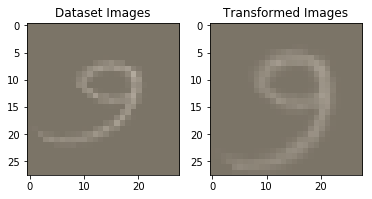

In [26]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(datasett))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1,10):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

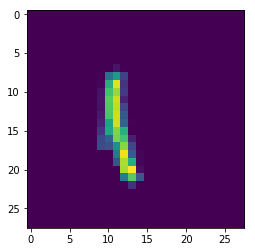

1


In [31]:
x = model(torch.FloatTensor(np.array([traind[1]]).reshape(1,1,28,28)))
plt.imshow(traind[1].reshape(28,28))
plt.show()
print(np.argmax(x.detach().numpy()))

In [32]:
s='testData/DigitTest'
name=[]
immatrix=[]
for x in os.listdir(s):
    im=cv2.imread(s+'/'+x,0)
    immatrix.append(im/256)
    name.append(os.path.splitext(x)[0])
test=np.array(immatrix).reshape((2510, 28, 28,1))
test.shape

(2510, 28, 28, 1)

In [33]:
ll=[]
for x in test:
    iki = model(torch.FloatTensor(np.array([x]).reshape(1,1,28,28)))
    l=(np.argmax(iki.detach().numpy()))
    ll.append(l)
print(ll[1])

6


In [34]:
with open('predictall.csv', mode='w') as pre:
    pre_writer = csv.writer(pre, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    pre_writer.writerow(['Id', 'Category'])
    for x in range(len(ll)):
        pre_writer.writerow([ll[x]])

In [ ]:
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32').flatten()